# Correlations with MT from Whitaker Vertes 2016

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [ ]:
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')
dk_scores = dm_hcp_3d_ds5.score_in_dk()
dk_null_grads = np.load(f"../outputs/permutations/hcp_3d_ds5_spin_5000_in_dk.npy")

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [196]:
dm_hcp_3d_ds5.clean_scores().to_csv("../outputs/ahba_axes_3d_ds5.csv")

In [182]:
(pd.read_csv('../data/whitakervertes2016_68.tex', sep='&', header=None)
    .replace(".*textless","",regex=True)
    .replace("\\\\","",regex=True)
    .replace(" ","",regex=True)
    .set_axis(['lobe','region','hemi','n_sub_regions','CT','CT_delta','CT_p','MT','MT_delta','MT_p','PLS2','degree','closeness'],axis=1)
    .assign(label = lambda x: x['hemi']+'h_'+x['region'])
    .assign(region = lambda x: pd.Categorical(x['region'], ordered=True, categories=dk_scores['label'].str.replace("lh_","")))
    .sort_values('region')
).to_csv("../data/whitakervertes2016_table.csv")

In [190]:
from statsmodels.stats.multitest import multipletests

ct_mt = (pd.read_csv("../data/whitakervertes2016_table.csv",index_col=0)
         .query('hemi=="l"')
         .assign(
            CT_q = lambda x: multipletests(x['CT_p'], method='fdr_bh')[1],
            MT_q = lambda x: multipletests(x['MT_p'], method='fdr_bh')[1]
         )
         .assign(
            CT = lambda x: np.where(x['CT_q']>0.05, np.nan, x['CT']),
            CT_delta = lambda x: np.where(x['CT_q']>0.05, np.nan, x['CT_delta']),
            MT = lambda x: np.where(x['MT_q']>0.05, np.nan, x['MT']),
            MT_delta = lambda x: np.where(x['MT_q']>0.05, np.nan, x['MT_delta'])
            )
         .assign(
            CT_delta = lambda x: x['CT_delta']/1000,
            MT_delta = lambda x: x['MT_delta']/1000
         )
         .set_index('label')
         .loc[:,['CT','CT_delta','MT','MT_delta']]
)

In [191]:
ct_mt_scatter = (ct_mt
    .melt(ignore_index=False, var_name='map', value_name='map_score')
    .join(dk_scores.set_index('label'))
    .melt(ignore_index=False, id_vars=['map','map_score'], var_name='G', value_name='G_score')
)

In [192]:
ct_mt_null_p = (corr_nulls_from_grads(dk_null_grads, dk_scores, ct_mt, method='pearsonr')
                .join(ct_mt_scatter.groupby(['map','G']).min(), on=('map','G'))
                .rename({'map_score':'y', 'G_score':'x'},axis=1)
)

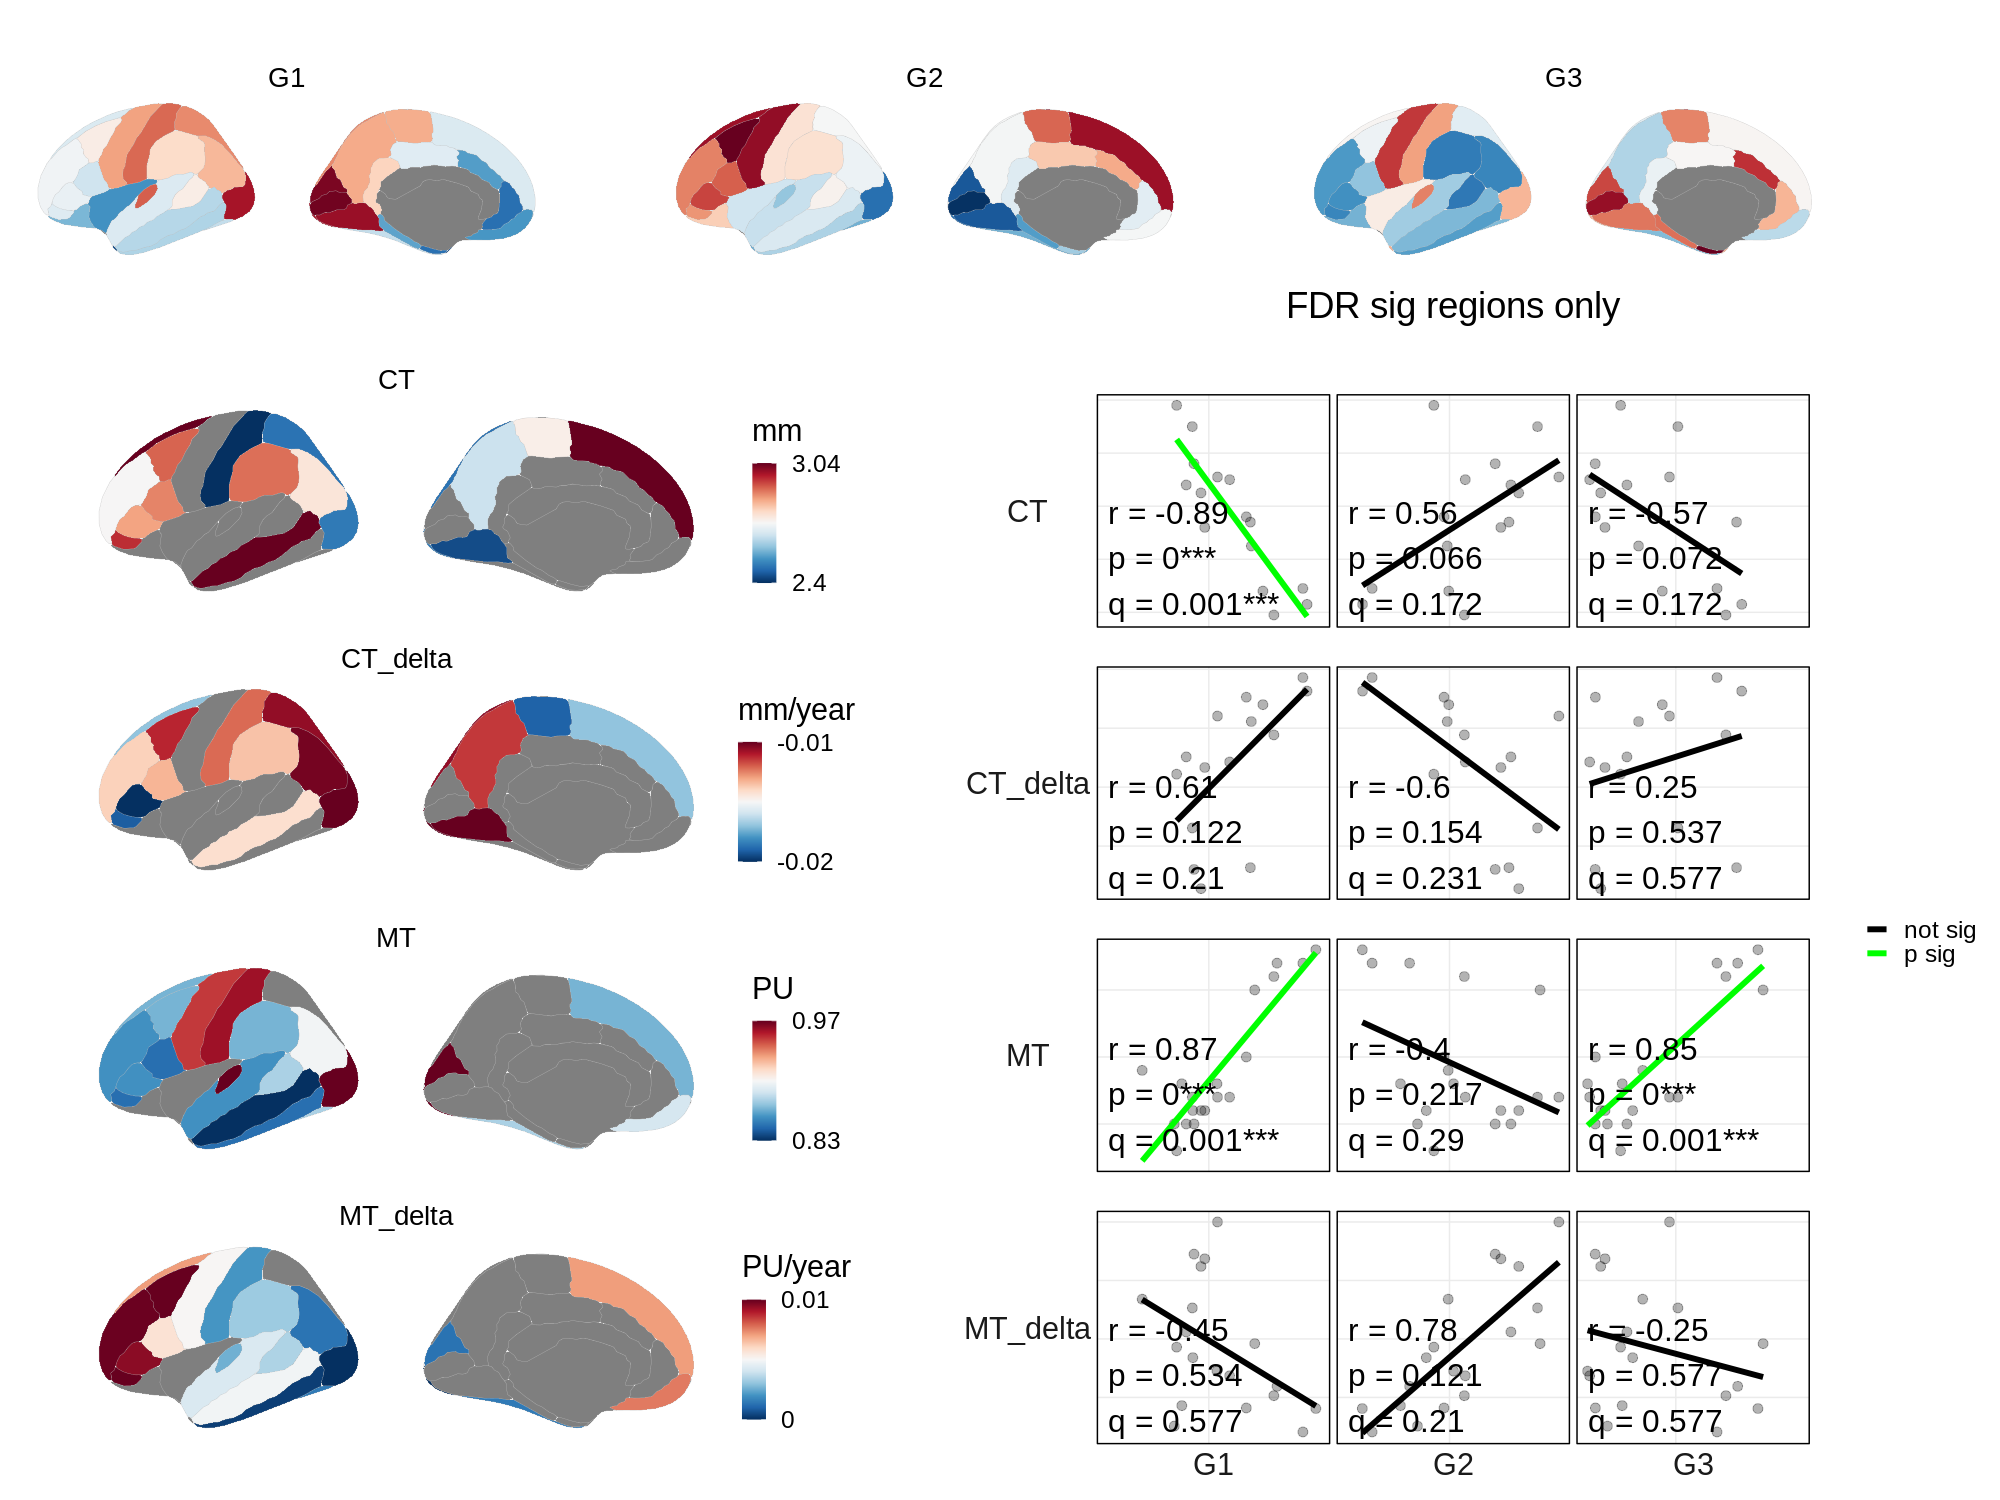

In [194]:
%%R -i dk_scores -i ct_mt -i ct_mt_scatter -i ct_mt_null_p -w 20 -h 15 --units in -r 100
source("../code/plot_maps.R")
ct <- plot_maps_dk(ct_mt %>% select(CT), colorscale='absolute',name='mm')
mt <- plot_maps_dk(ct_mt %>% select(MT), colorscale='absolute',name='PU')
ct_delta <- plot_maps_dk(ct_mt %>% select(CT_delta), colorscale='absolute',name='mm/year')
mt_delta <- plot_maps_dk(ct_mt %>% select(MT_delta), colorscale='absolute',name='PU/year')

g0 <- plot_dk_wide(dk_scores) + guides(fill='none')
g <- plot_maps_scatter(ct_mt_scatter, ct_mt_null_p) + 
    theme(panel.border=element_rect(fill=NA), panel.spacing.y=unit(2,'lines')) + 
    ggtitle('FDR sig regions only')

(g0 / ((ct / ct_delta / mt / mt_delta) | g) + plot_layout(heights=c(1,5))) & 
theme(legend.position='right', text=element_text(size=22), strip.text=element_text(size=22))

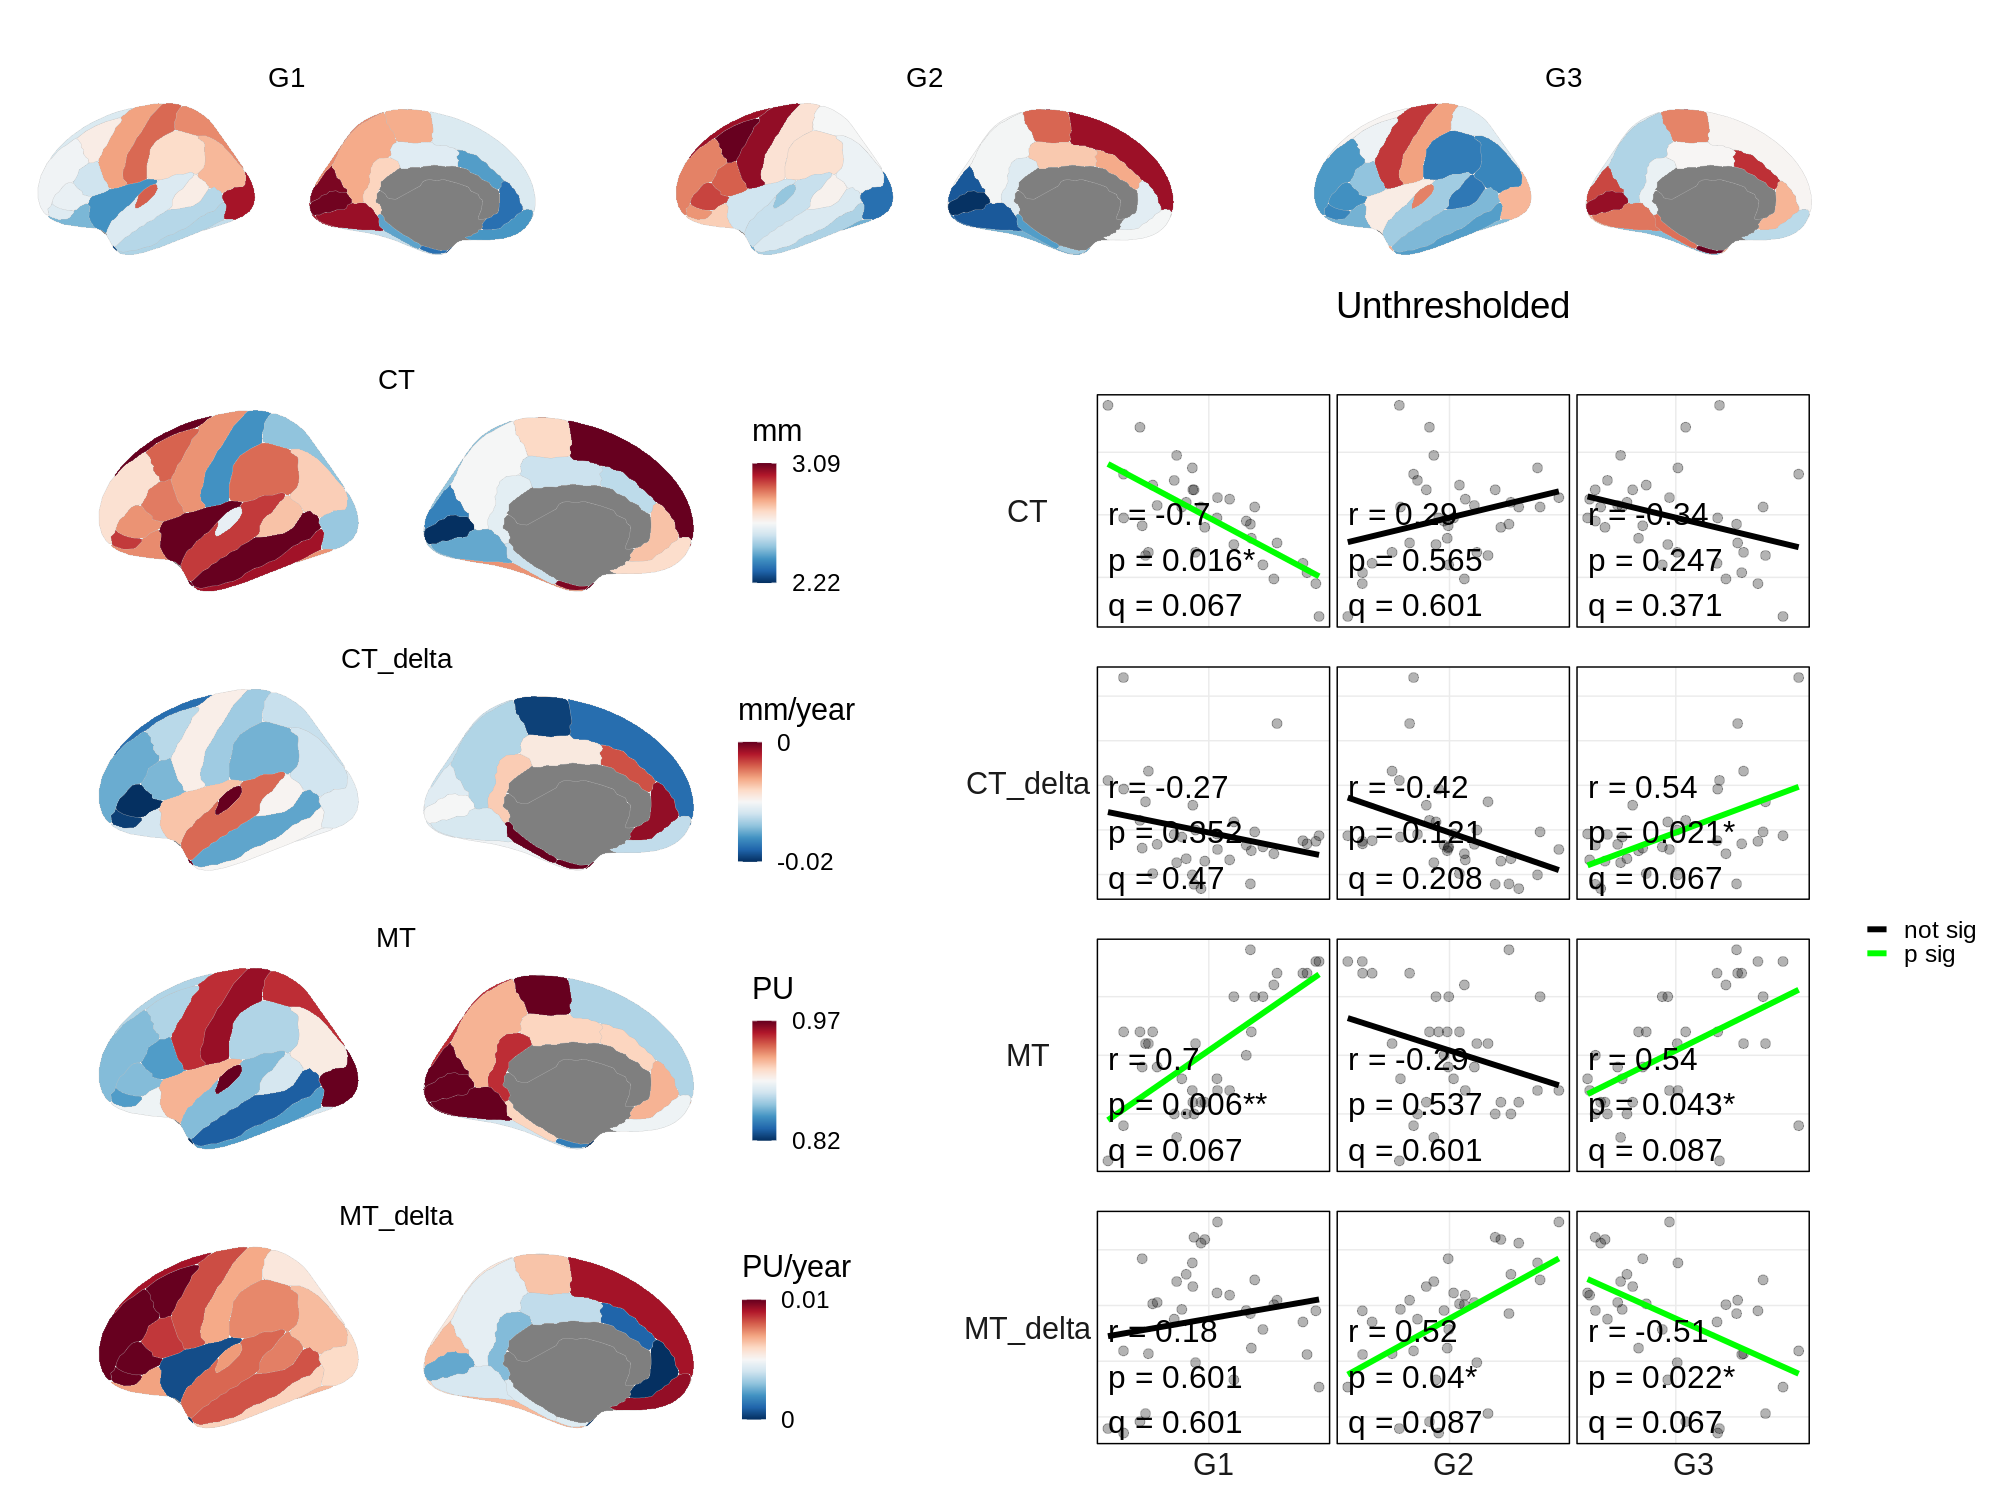

In [189]:
%%R -i dk_scores -i ct_mt -i ct_mt_scatter -i ct_mt_null_p -w 20 -h 15 --units in -r 100
source("../code/plot_maps.R")
ct <- plot_maps_dk(ct_mt %>% select(CT), colorscale='absolute',name='mm')
mt <- plot_maps_dk(ct_mt %>% select(MT), colorscale='absolute',name='PU')
ct_delta <- plot_maps_dk(ct_mt %>% select(CT_delta), colorscale='absolute',name='mm/year')
mt_delta <- plot_maps_dk(ct_mt %>% select(MT_delta), colorscale='absolute',name='PU/year')

g0 <- plot_dk_wide(dk_scores) + guides(fill='none')
g <- plot_maps_scatter(ct_mt_scatter, ct_mt_null_p) + 
    theme(panel.border=element_rect(fill=NA), panel.spacing.y=unit(2,'lines')) + 
    ggtitle('Unthresholded')

(g0 / ((ct / ct_delta / mt / mt_delta) | g) + plot_layout(heights=c(1,5))) & 
theme(legend.position='right', text=element_text(size=22), strip.text=element_text(size=22))